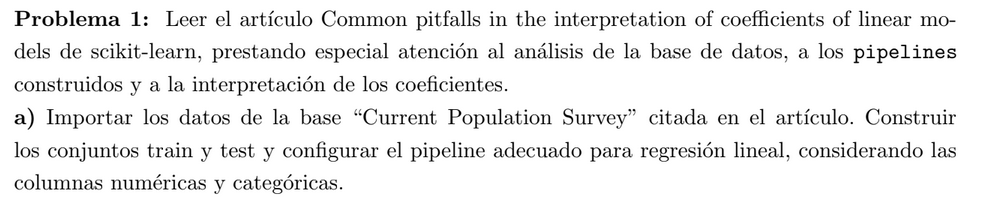

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
from sklearn.datasets import fetch_openml


survey = fetch_openml(data_id=534, as_frame=True)
X = survey.data[survey.feature_names]
X.describe(include="all")


,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
count,534.000000,534,534,534.000000,534,534.000000,534,534,534,534
unique,NaN,2,2,NaN,2,NaN,3,6,3,2
top,NaN,no,male,NaN,not_member,NaN,White,Other,Other,Married
freq,NaN,378,289,NaN,438,NaN,440,156,411,350
mean,13.018727,NaN,NaN,17.822097,NaN,36.833333,NaN,NaN,NaN,NaN
std,2.615373,NaN,NaN,12.379710,NaN,11.726573,NaN,NaN,NaN,NaN
min,2.000000,NaN,NaN,0.000000,NaN,18.000000,NaN,NaN,NaN,NaN
25%,12.000000,NaN,NaN,8.000000,NaN,28.000000,NaN,NaN,NaN,NaN
50%,12.000000,NaN,NaN,15.000000,NaN,35.000000,NaN,NaN,NaN,NaN
75%,15.000000,NaN,NaN,26.000000,NaN,44.000000,NaN,NaN,NaN,NaN


In [ ]:
#Queremos predecir wage

y = survey.target.values.ravel()
survey.target.head()

,WAGE
0,5.10
1,4.95
2,6.67
3,4.00
4,7.50


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

First, let’s get some insights by looking at the variable distributions and at the pairwise relationships between them. Only numerical variables will be used. In the following plot, each dot represents a sample.

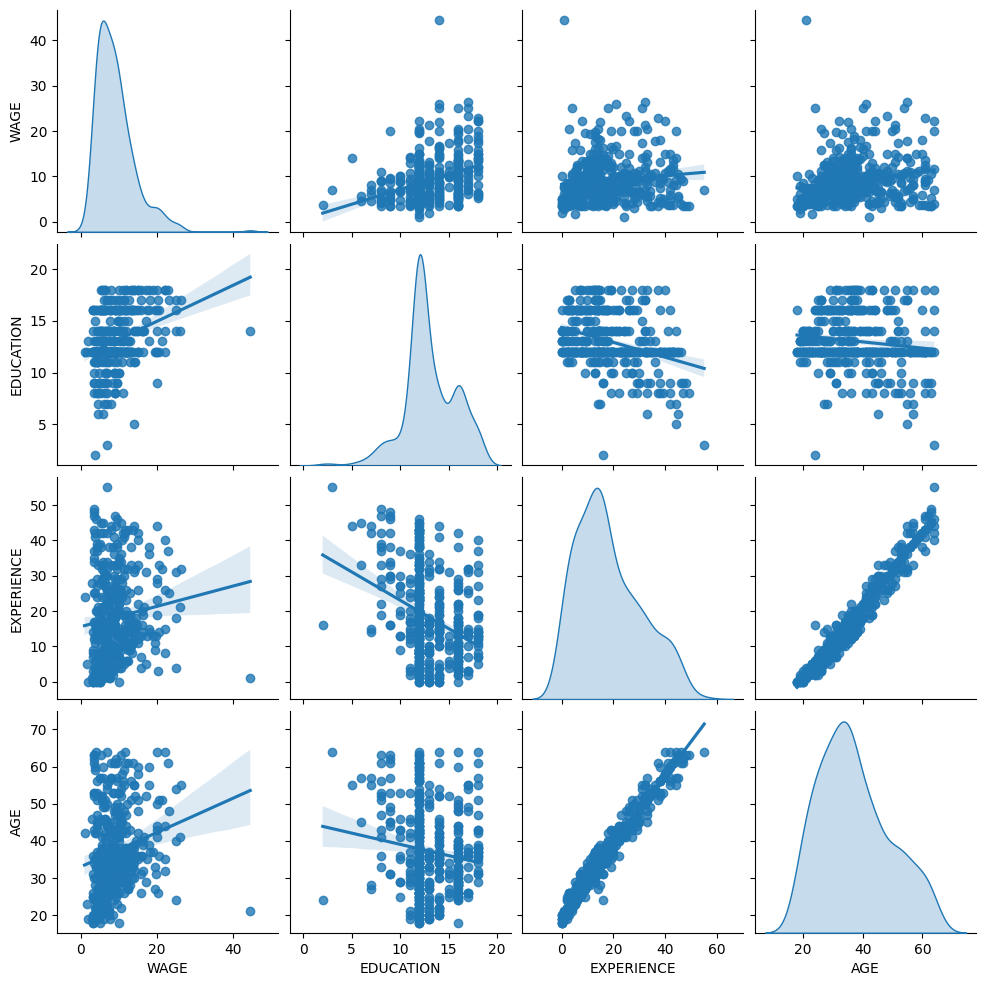

In [ ]:
train_dataset = X_train.copy()
train_dataset.insert(0, "WAGE", y_train)
_ = sns.pairplot(train_dataset, kind="reg", diag_kind="kde")

In [ ]:
survey.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   EDUCATION   534 non-null    int64   
 1   SOUTH       534 non-null    category
 2   SEX         534 non-null    category
 3   EXPERIENCE  534 non-null    int64   
 4   UNION       534 non-null    category
 5   AGE         534 non-null    int64   
 6   RACE        534 non-null    category
 7   OCCUPATION  534 non-null    category
 8   SECTOR      534 non-null    category
 9   MARR        534 non-null    category
dtypes: category(7), int64(3)
memory usage: 17.3 KB


the dataset contains columns with different data types and we need to apply a specific preprocessing for each data types. In particular categorical variables cannot be included in linear model if not coded as integers first. In addition, to avoid categorical features to be treated as ordered values, we need to one-hot-encode them

In [ ]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

categorical_columns = ["RACE", "OCCUPATION", "SECTOR", "MARR", "UNION", "SEX", "SOUTH"]
numerical_columns = ["EDUCATION", "EXPERIENCE", "AGE"]

preprocessor = make_column_transformer(
    (OneHotEncoder(drop="if_binary"), categorical_columns),
    remainder="passthrough",
    verbose_feature_names_out=False,  # avoid to prepend the preprocessor names
)

In [ ]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Ridge(alpha=1e-10), func=np.log10, inverse_func=sp.special.exp10
    ),
)

In [ ]:
model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR', 'UNION',
                                                   'SEX', 'SOUTH'])],
                                   verbose_feature_names_out=False)),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=Ridge(alpha=1e-10)))])

Aca hago con HuberRegression




/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


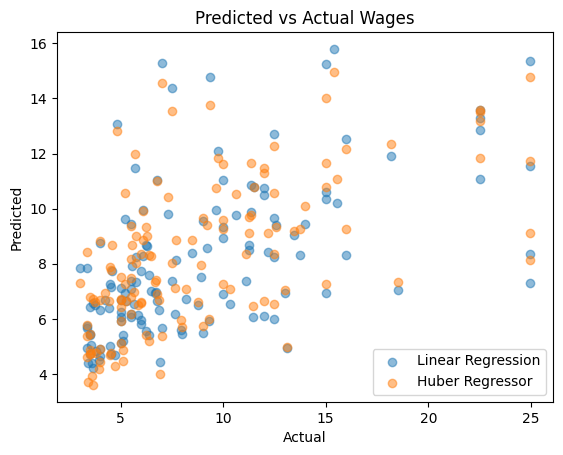

MAE LinearRegression: 3.045474742449743
MAE HuberRegressor: 3.0094597171008473


In [ ]:
from sklearn.linear_model import HuberRegressor
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

pipeline_huber = make_pipeline(
    preprocessor,
    HuberRegressor(),
)

pipeline_huber.fit(X_train, y_train)

y_pred_lr = model.predict(X_test)
y_pred_huber = pipeline_huber.predict(X_test)

plt.scatter(y_test, y_pred_lr, alpha=0.5, label="Linear Regression")
plt.scatter(y_test, y_pred_huber, alpha=0.5, label="Huber Regressor")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()
plt.title("Predicted vs Actual Wages")
plt.show()

print("MAE LinearRegression:", mean_absolute_error(y_test, y_pred_lr))
print("MAE HuberRegressor:", mean_absolute_error(y_test, y_pred_huber))


Vemos que las predicciones no son muy buenas. Los puntos deberian estar en la recta f(x) = x

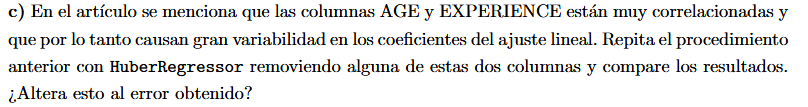

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


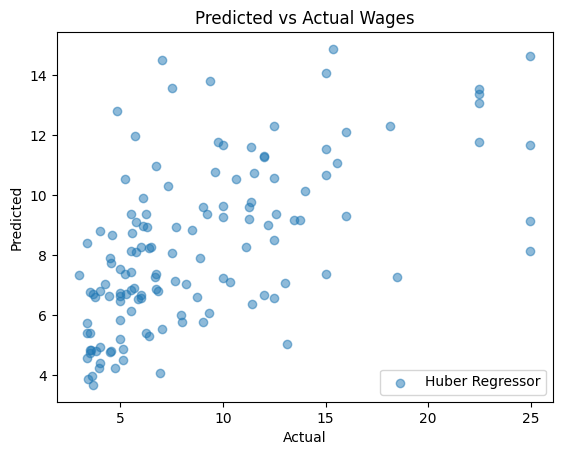

MAE HuberRegressor: 3.013396762501913


In [ ]:
from sklearn.linear_model import HuberRegressor
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

X = X.drop('AGE', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

pipeline_huber.fit(X_train, y_train)

y_pred_huber = pipeline_huber.predict(X_test)

plt.scatter(y_test, y_pred_huber, alpha=0.5, label="Huber Regressor")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()
plt.title("Predicted vs Actual Wages")
plt.show()

print("MAE HuberRegressor:", mean_absolute_error(y_test, y_pred_huber))


El error queda igual que antes, o muy parecido. Dicha columna no estaba aportando nada.

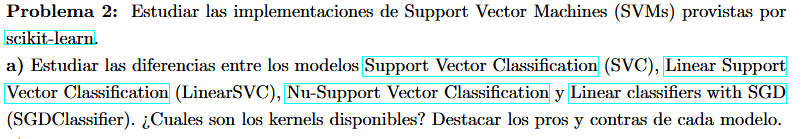

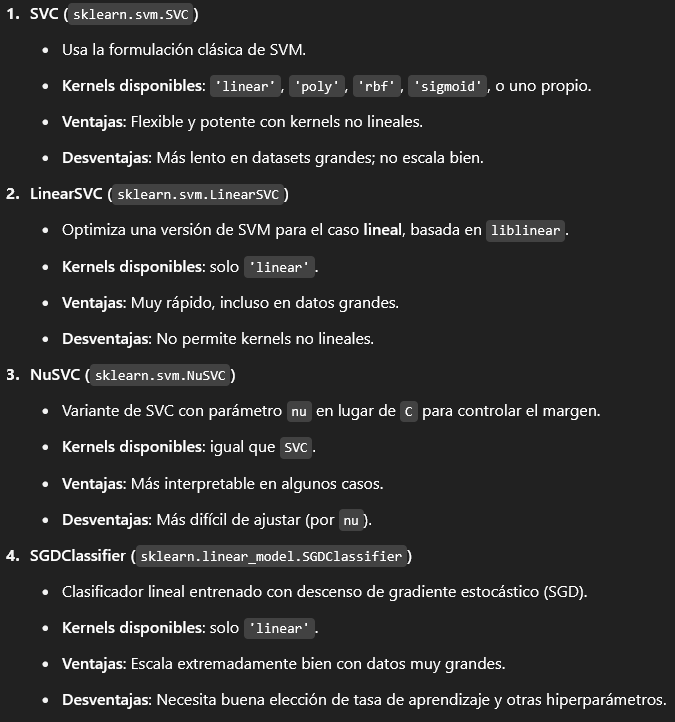
  

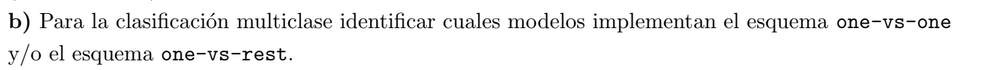

b) One vs Rest es la idea de transformar un problema de clasificacion multiple en binario dejando una sola clase como la principal a predecir, y las demas como una sola clase cambiando su etiqueta. Para predecir se busca devolver un valor en forma de porcentaje, y la clase con mas porcentaje es la elegida.

One vs One crea un modelo por par de categorias a predecir. Para una prediccion la idea es correrla en cada modelo y la clase que mas fue predicha va a ser la clase elegida por One vs one.

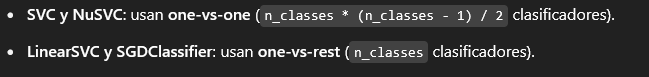

Es **muy relevante** saber si un modelo usa **one-vs-one (OvO)** o **one-vs-rest (OvR)** porque afecta a:

---

### ✅ 1. **Complejidad computacional**

* **OvO** entrena $\frac{n(n-1)}{2}$ clasificadores si hay $n$ clases.

  * Ejemplo: para 10 clases, se entrenan 45 clasificadores.
  * **Más costoso** computacionalmente.
* **OvR** entrena solo $n$ clasificadores.

  * Para 10 clases, son 10 modelos.
  * **Más eficiente**.

---

### ✅ 2. **Interpretabilidad**

* **OvR** es más interpretable: cada modelo intenta distinguir una clase contra todas las demás.

  * Se puede entender mejor qué contribuye a cada clase.
* **OvO** compara cada par de clases, y puede ser más difícil seguir cómo se combinan las decisiones.

---

### ✅ 3. **Rendimiento**

* **OvO** puede tener mejor rendimiento en casos donde:

  * Las clases están muy **separadas de a pares**, pero mal definidas globalmente.
  * Hay **clases difíciles de distinguir sólo frente al resto**.
* **OvR** puede fallar si una clase es muy parecida a varias otras.

---

### ✅ 4. **Implicaciones prácticas**

* Algunos modelos (como `SVC`) no permiten cambiar el esquema, ya vienen con OvO.
* Otros (`SGDClassifier`, `LinearSVC`) usan OvR y se integran mejor con problemas con muchas clases.

---

### 📌 Ejemplo práctico:

Si tenés que clasificar tipos de flores y hay 3 especies:

* OvO entrena:

  * modelo A vs B,
  * modelo A vs C,
  * modelo B vs C.
* OvR entrena:

  * modelo A vs (B+C),
  * modelo B vs (A+C),
  * modelo C vs (A+B).

La decisión final en OvO se hace por votación, en OvR se toma el score más alto.

---

### 👉 ¿Por qué te preguntan esto?

Porque entender el esquema te ayuda a:

* Elegir el modelo más adecuado según tu problema (¿muchas clases? ¿desbalance?).
* Saber cuántos clasificadores estás entrenando y cómo interpretarlos.
* Diagnosticar errores de clasificación (confusiones sistemáticas entre pares de clases → mejor OvO).

¿Querés que te dé recomendaciones de qué usar en distintos escenarios concretos?


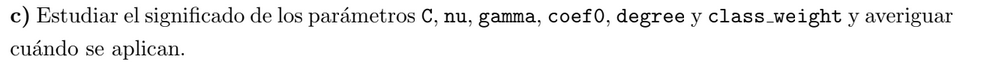



* **C** (`SVC`, `LinearSVC`, `SGDClassifier`):

  * Controla la penalización por error.
  * **C alto**: menos regularización, más sobreajuste.
  * **C bajo**: más regularización, modelo más simple.

* **nu** (`NuSVC`):

  * Cota superior de errores y cota inferior de soporte.
  * Alternativa a `C`.

* **gamma** (`SVC`, `NuSVC`):

  * Parámetro del kernel RBF, polinomial y sigmoidal.
  * **Gamma alto**: fronteras más curvas (sobreajuste).
  * **Gamma bajo**: fronteras más suaves (subajuste).

* **coef0** (`SVC`, `NuSVC` con `'poly'` o `'sigmoid'` kernel):

  * Término independiente en kernels polinomiales y sigmoides.

* **degree** (`SVC`, `NuSVC` con `'poly'` kernel):

  * Grado del polinomio en kernel polinomial.

* **class\_weight** (todos los modelos):

  * Pondera las clases según su frecuencia (`'balanced'` lo hace automáticamente).
  * Útil en datasets desbalanceados.



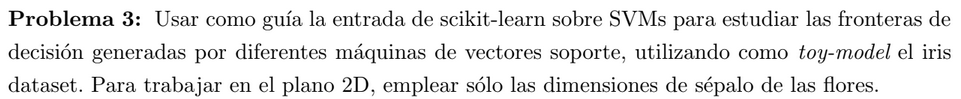

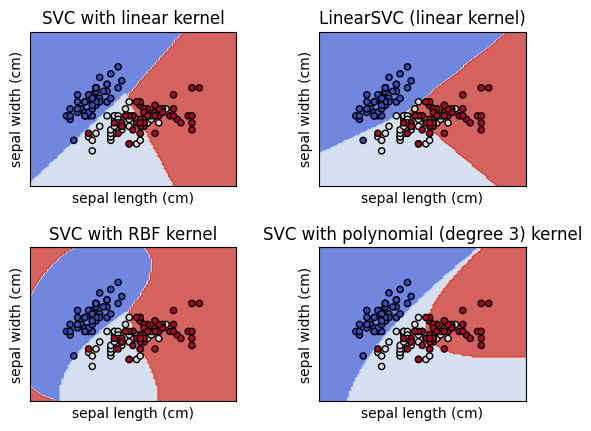

In [ ]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import matplotlib.pyplot as plt

from sklearn import datasets, svm
from sklearn.inspection import DecisionBoundaryDisplay

# import some data to play with
iris = datasets.load_iris()
# Take the first two features. We could avoid this by using a two-dim dataset
X = iris.data[:, :2]
y = iris.target

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
models = (
    svm.SVC(kernel="linear", C=C),
    svm.LinearSVC(C=C, max_iter=10000),
    svm.SVC(kernel="rbf", gamma=0.7, C=C),
    svm.SVC(kernel="poly", degree=3, gamma="auto", C=C),
)
models = (clf.fit(X, y) for clf in models)

# title for the plots
titles = (
    "SVC with linear kernel",
    "LinearSVC (linear kernel)",
    "SVC with RBF kernel",
    "SVC with polynomial (degree 3) kernel",
)

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X[:, 0], X[:, 1]

for clf, title, ax in zip(models, titles, sub.flatten()):
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        response_method="predict",
        cmap=plt.cm.coolwarm,
        alpha=0.8,
        ax=ax,
        xlabel=iris.feature_names[0],
        ylabel=iris.feature_names[1],
    )
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()

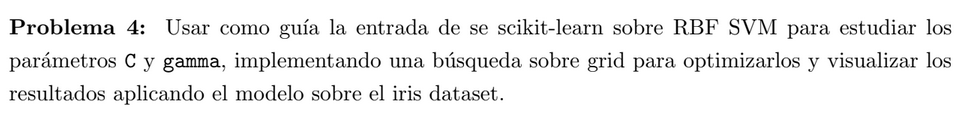

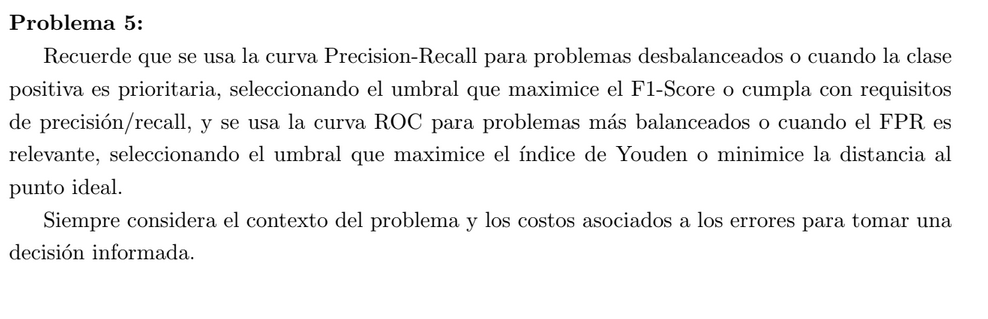

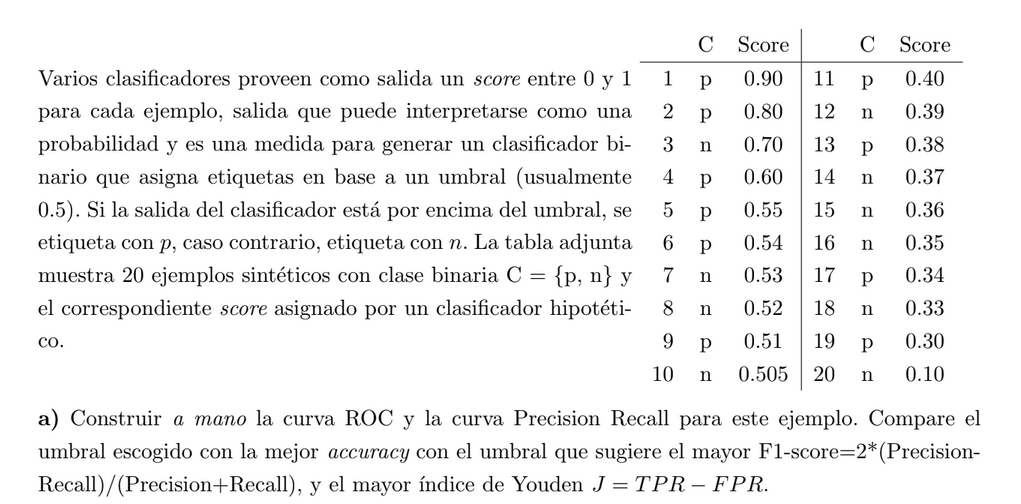

In [ ]:
scores = [0.9, 0.8, 0.8, 0.6, 0.55, 0.54, 0.53, 0.52, 0.51, 0.505, 0.4, 0.39, 0.38, 0.37, 0.36, 0.35, 0.34, 0.33, 0.3, 0.1]

c = [1,1,0,1,1,1,0,0,1,0,1,0,1,0,0,0,1,0,1,0]

print(len(c), len(scores))

20 20


El umbral que maximiza la accuracy es 0.54 con una accuracy de 0.7
El umbral que maximiza el f1 es 0.38 con un valor de 0.6956521739130435
El umbral que maximiza el indice de youden es 0.54 con un valor de 0.4


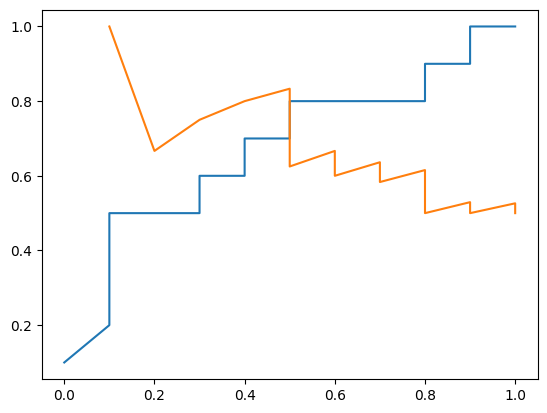

In [ ]:
fps=[]
tps=[]
tns=[]
fns=[]


#ROC
for score in scores:
  #uso cada score como umbral
  preds = []
  for s in scores:
    if s>=score: preds.append(1)
    else: preds.append(0)
  #calculo los tp y los fp
  tp = 0
  fp = 0
  tn = 0
  fn = 0
  for i in range(len(scores)):
    if (preds[i] == 1) and (c[i] == 1):
      tp+=1
    elif (preds[i] == 1) and (c[i] == 0):
      fp+=1
    elif (preds[i] == 0) and (c[i] == 0):
      tn+=1
    elif (preds[i] == 0) and (c[i] == 1):
      fn+=1

  fps.append(fp)
  tps.append(tp)
  tns.append(tn)
  fns.append(fn)

#Calculo las accuracy
acc = [(tps[i]+tns[i])/20 for i in range(len(fps))]
max_acc = max(acc)
umbral_acc = scores[acc.index(max_acc)]

print(f"El umbral que maximiza la accuracy es {umbral_acc} con una accuracy de {max_acc}")

#Calculo F1-score's
f1s = [tps[i]/(tps[i]+0.5*(fps[i]+fns[i])) for i in range(len(fps))]
max_f1 = max(f1s)
umbral_f1 = scores[f1s.index(max_f1)]

print(f"El umbral que maximiza el f1 es {umbral_f1} con un valor de {max_f1}")

#Calculo de younden
youdens = [(tps[i]/(tps[i]+fns[i]))- (fps[i]/(fps[i]+tns[i])) for i in range(len(fps))]
max_yn = max(youdens)
umbral_yn = scores[youdens.index(max_yn)]

print(f"El umbral que maximiza el indice de youden es {umbral_yn} con un valor de {max_yn}")

import matplotlib.pyplot as plt

#calculo el false positive rate y true positive rate
fpr = [fps[i]/((fps[i]+tns[i])) for i in range(len(fps))]
recall = [tps[i]/((tps[i]+fns[i])) for i in range(len(tps))]

#Curva ROC
plt.plot(fpr, recall)

#Calculo precision
precision = [tps[i]/((tps[i]+fps[i])) for i in range(len(tps))]

#Curva PR
plt.plot(recall, precision)


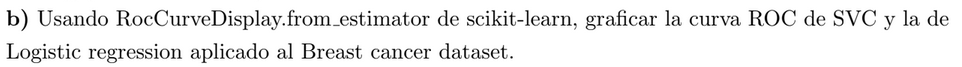

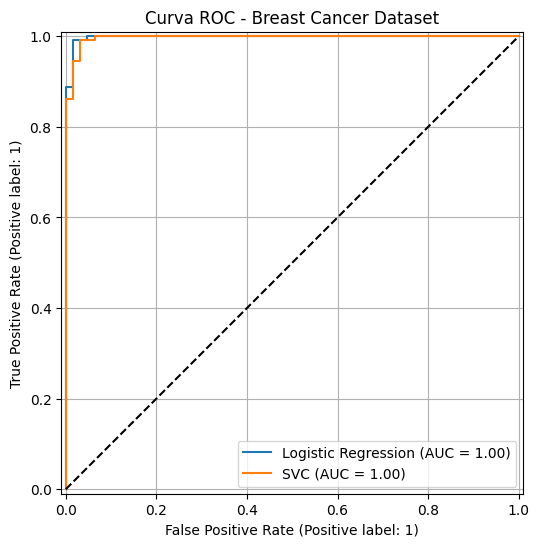

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import RocCurveDisplay

# 1. Cargar datos
X, y = load_breast_cancer(return_X_y=True)

# 2. Separar en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 3. Escalar datos (necesario para SVC)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Modelos
svc = SVC(probability=True, random_state=42)  # importante: probability=True para ROC
log_reg = LogisticRegression(max_iter=10000, random_state=42)

svc.fit(X_train_scaled, y_train)
log_reg.fit(X_train_scaled, y_train)

# 5. Graficar curva ROC
plt.figure(figsize=(8, 6))

RocCurveDisplay.from_estimator(log_reg, X_test_scaled, y_test, name="Logistic Regression", ax=plt.gca())
RocCurveDisplay.from_estimator(svc, X_test_scaled, y_test, name="SVC", ax=plt.gca())

plt.plot([0, 1], [0, 1], 'k--')  # línea diagonal
plt.title("Curva ROC - Breast Cancer Dataset")
plt.grid(True)
plt.show()



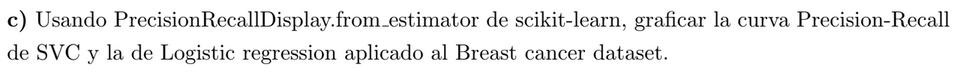

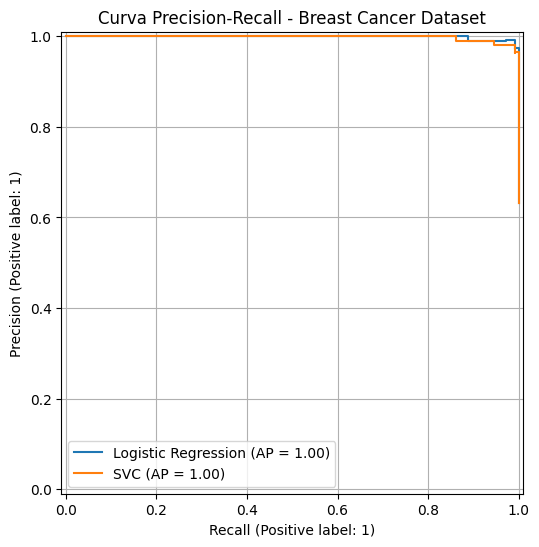

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import PrecisionRecallDisplay

# 1. Cargar datos
X, y = load_breast_cancer(return_X_y=True)

# 2. Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 3. Escalar características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Inicializar modelos
svc = SVC(probability=True, random_state=42)  # Necesita probability=True para obtener probabilidades
log_reg = LogisticRegression(max_iter=10000, random_state=42)

# 5. Entrenar modelos
svc.fit(X_train_scaled, y_train)
log_reg.fit(X_train_scaled, y_train)

# 6. Graficar curva Precision-Recall
plt.figure(figsize=(8, 6))

PrecisionRecallDisplay.from_estimator(log_reg, X_test_scaled, y_test, name="Logistic Regression", ax=plt.gca())
PrecisionRecallDisplay.from_estimator(svc, X_test_scaled, y_test, name="SVC", ax=plt.gca())

plt.title("Curva Precision-Recall - Breast Cancer Dataset")
plt.grid(True)
plt.show()


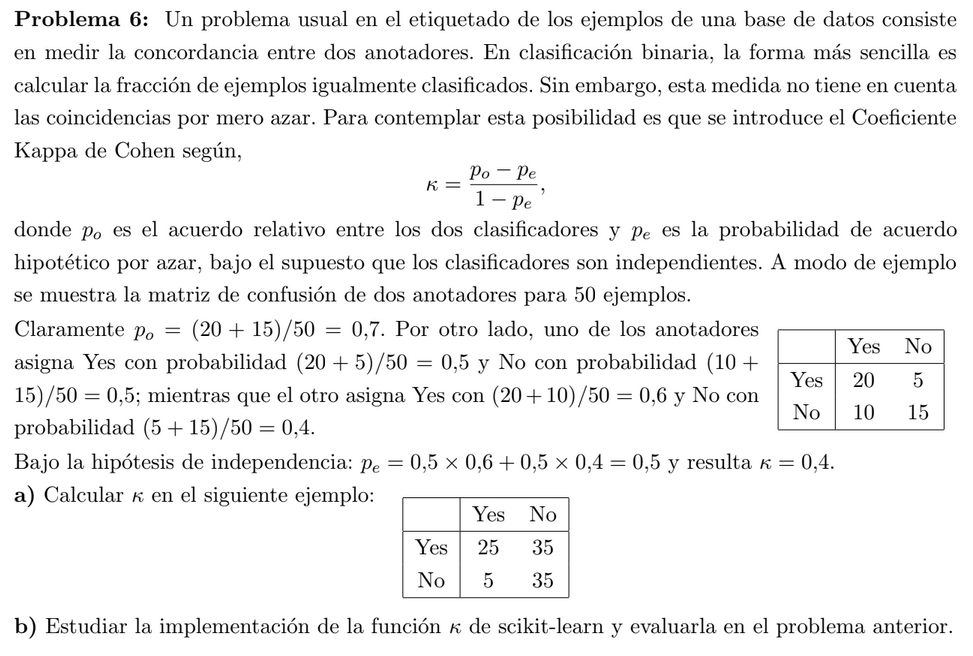

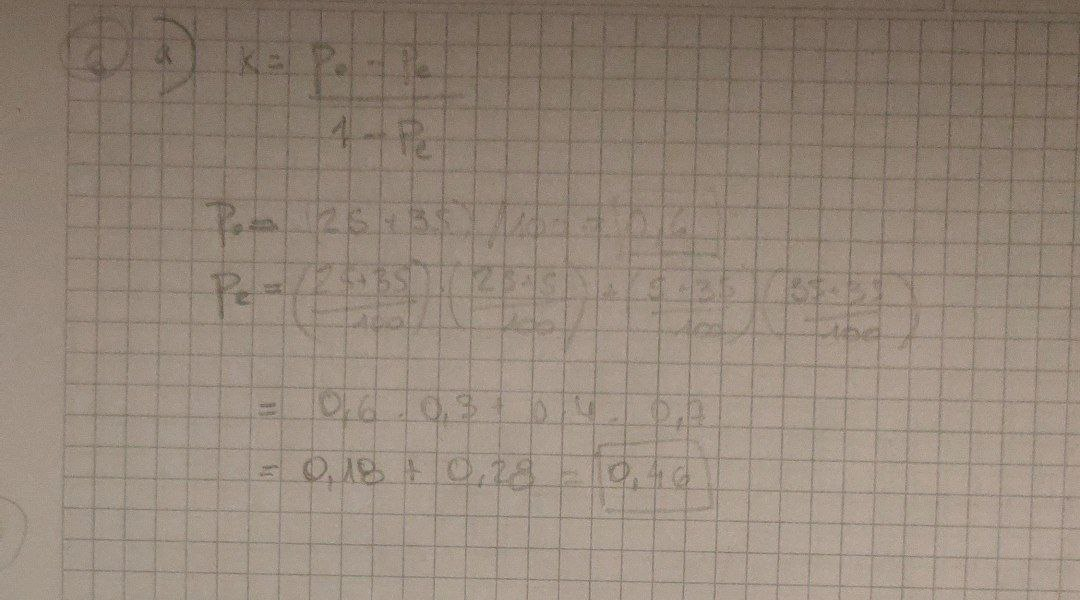

In [ ]:
from sklearn.metrics import cohen_kappa_score

y1 = [1 for i in range(25)] + [1 for i in range(35)] + [0 for i in range(5)] + [0 for i in range(35)]

y2 = [1 for i in range(25)] + [0 for i in range(35)] + [1 for i in range(5)] + [0 for i in range(35)]

cohen_kappa_score(y1, y2)

np.float64(0.2592592592592593)